In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import functions as fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import time
from skimage.morphology import binary_dilation
import json
from tqdm import tqdm
import pandas as pd

In [2]:
fn = glob.glob('/DATA/vito/output/ran_synth_08_bw/*')
fn.sort()
para_list=[]
for fn_pth in fn:
    with open(fn_pth+'/init_para.json', 'r') as json_file:
        para_list.append(json.load(json_file))

In [3]:
init_para=para_list[4]
OutDIR=init_para.get('OutDIR')
DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')
resample_factor=init_para.get('resample_factor')
b=init_para.get('b')
crop_size=init_para.get('crop_size')

image=fnc.load_image(DataDIR,DSname,fid)


img_04.npy imported


In [4]:
print('Image size:', image.shape)
if resample_factor!=1:
    pre_para={'Resample': {'fxy':resample_factor},
        #'Gaussian': {'kernel size':3}
        #'CLAHE':{'clip limit':2}#,
        #'Downsample': {'fxy':4},
        #'Buffering': {'crop size': crop_size}
        }

    image_dw=fnc.preprocessing_roulette(image, pre_para)
    print('resampled to: ', image.shape)

seg_masks=np.array(np.load(OutDIR+'Third/all_mask_third_pass_id.npy', allow_pickle=True))

print('masks size:', seg_masks.shape)
print(len(np.unique(seg_masks)),' mask(s) loaded')


Image size: (20000, 20000, 3)
resampled to:  (20000, 20000, 3)
masks size: (5000, 5000)
1831  mask(s) loaded


In [5]:
fn_img = glob.glob(DataDIR+DSname[:-5]+'msk/*')
fn_img.sort()
mask=(np.load(fn_img[fid])).astype(np.uint16)
mask_dw=fnc.resample_fnc(mask,{'target_size':image_dw.shape[:-1][::-1], 'method':'nearest'})
seg_masks_rs=fnc.resample_fnc(seg_masks.astype(np.uint16),{'target_size':mask.shape[::-1], 'method':'nearest'})
print(fn_img[fid].split("/")[-1]+' imported')
print('No. of objects: '+str(len(np.unique(mask))-1))
print('resampled shape: ', mask_dw.shape)

msk_04.npy imported
No. of objects: 4039
resampled shape:  (5000, 5000)


(np.float64(-0.5), np.float64(19999.5), np.float64(19999.5), np.float64(-0.5))

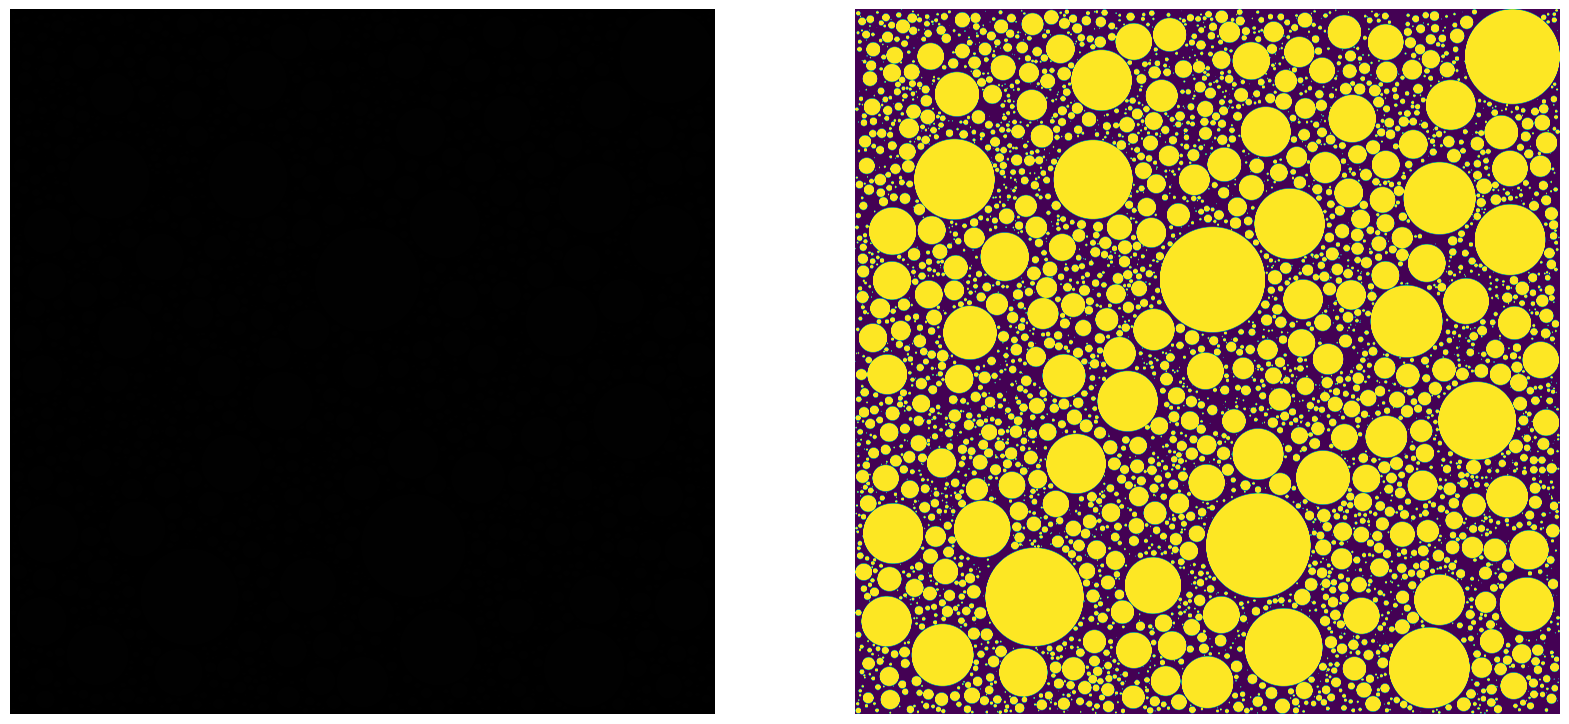

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask>0)
plt.axis('off')

In [6]:
seg_ids=np.unique(seg_masks)
centroids=[fnc.get_centroid(seg_masks==id) for id in seg_ids]
centroids=np.array(centroids)/resample_factor

In [7]:
ids, counts=np.unique(mask, return_counts=True)

ids, counts = ids[1:], counts[1:]
area = counts * (0.2 * 0.2)

ids = ids[np.argsort(area)]
counts = counts[np.argsort(area)]
area = np.sort(area)

In [8]:
#point based
point_based_ac=np.zeros_like(ids)

for i in range(len(centroids))[1:]:
    hit_id=int(mask[int(centroids[i][0]),int(centroids[i][1])])
    point_based_ac[ids==hit_id]+=1


In [11]:
#mask iou ac
mask_ious=np.zeros_like(ids).astype(np.float64)
for i in range(len(centroids))[1:]:
    hit_id=int(mask[int(centroids[i][0]),int(centroids[i][1])])
    current_iou=mask_ious[ids==hit_id]
    iou=fnc.iou(seg_masks_rs==seg_ids[i], mask==hit_id)
    if iou>current_iou:
        mask_ious[ids==hit_id]=iou

In [9]:
import cupy as cp

def compute_iou_gpu(centroids, mask, ids, seg_masks_rs):
    mask_ious = cp.zeros_like(ids).astype(cp.float64)
    centroids = cp.array(centroids)
    mask = cp.array(mask)
    ids = cp.array(ids)
    seg_masks_rs = cp.array(seg_masks_rs)

    for i in range(0, len(centroids)):
        hit_id = int(mask[int(centroids[i][0]), int(centroids[i][1])])
        current_iou = mask_ious[ids == hit_id]
        iou = fnc.iou(seg_masks_rs == seg_ids[i], mask == hit_id)  # Ensure `fnc.iou` supports CuPy arrays
        if iou > current_iou:
            mask_ious[ids == hit_id] = iou

    return cp.asnumpy(mask_ious)

In [11]:
mask_ious=compute_iou_gpu(centroids[1:], mask, ids, seg_masks_rs)

RuntimeError: CuPy failed to load libnvrtc.so.12: OSError: libnvrtc.so.12: cannot open shared object file: No such file or directory

In [ ]:
fnc=reload(fnc)
mask_ious = fnc.update_mask_ious_parallel(centroids[1:], mask, ids, seg_masks_rs, seg_ids[1:])
np.mean(mask_ious)

In [9]:
fnc=reload(fnc)
mask_ious = fnc.update_mask_ious_shared(centroids[1:], mask, ids
                                        , seg_masks_rs, seg_ids[1:])
np.mean(mask_ious)

np.float64(0.4339830722701745)

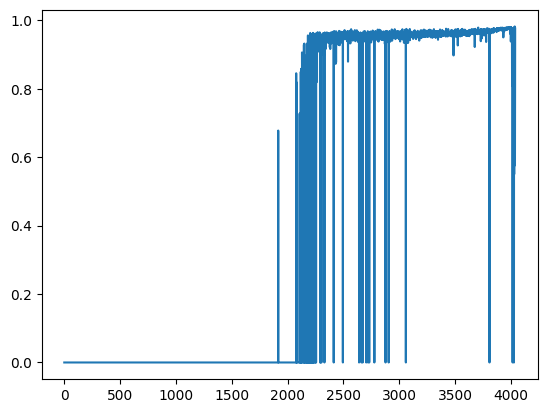

In [10]:
plt.plot(mask_ious)

In [ ]:
#np.save(OutDIR+'point_based_ac.npy', [point_based_ac, mask_ious, area])

In [66]:
def batch_process_iou(mask, centroids, seg_masks_rs, ids):
    # Initialize IOU array
    mask_ious = np.zeros_like(ids, dtype=np.float64)
    
    # Precompute hit_ids using centroids
    hit_ids = np.array([int(mask[int(c[0]), int(c[1])]) for c in centroids[1:]])
    
    # Identify unique IDs and their masks
    unique_ids = np.unique(hit_ids)
    unique_ids = unique_ids[unique_ids > 0]  # Exclude background
    
    # Create a mapping of seg_masks_rs regions
    seg_masks_regions = {i: (seg_masks_rs == i) for i in range(1, len(centroids))}
    
    # Process each unique ID
    mask_regions = (mask == unique_ids[:, None, None])  # Efficiently create all regions
    for idx, unique_id in enumerate(unique_ids):
        mask_region = mask_regions[idx]
        for region_id, ar_mask_region in seg_masks_regions.items():
            current_iou = iou(ar_mask_region, mask_region)
            mask_ious[ids == unique_id] = max(mask_ious[ids == unique_id], current_iou)
    
    return mask_ious


mask_ious2 = batch_process_iou(mask, centroids, seg_masks_rs, ids)

: 

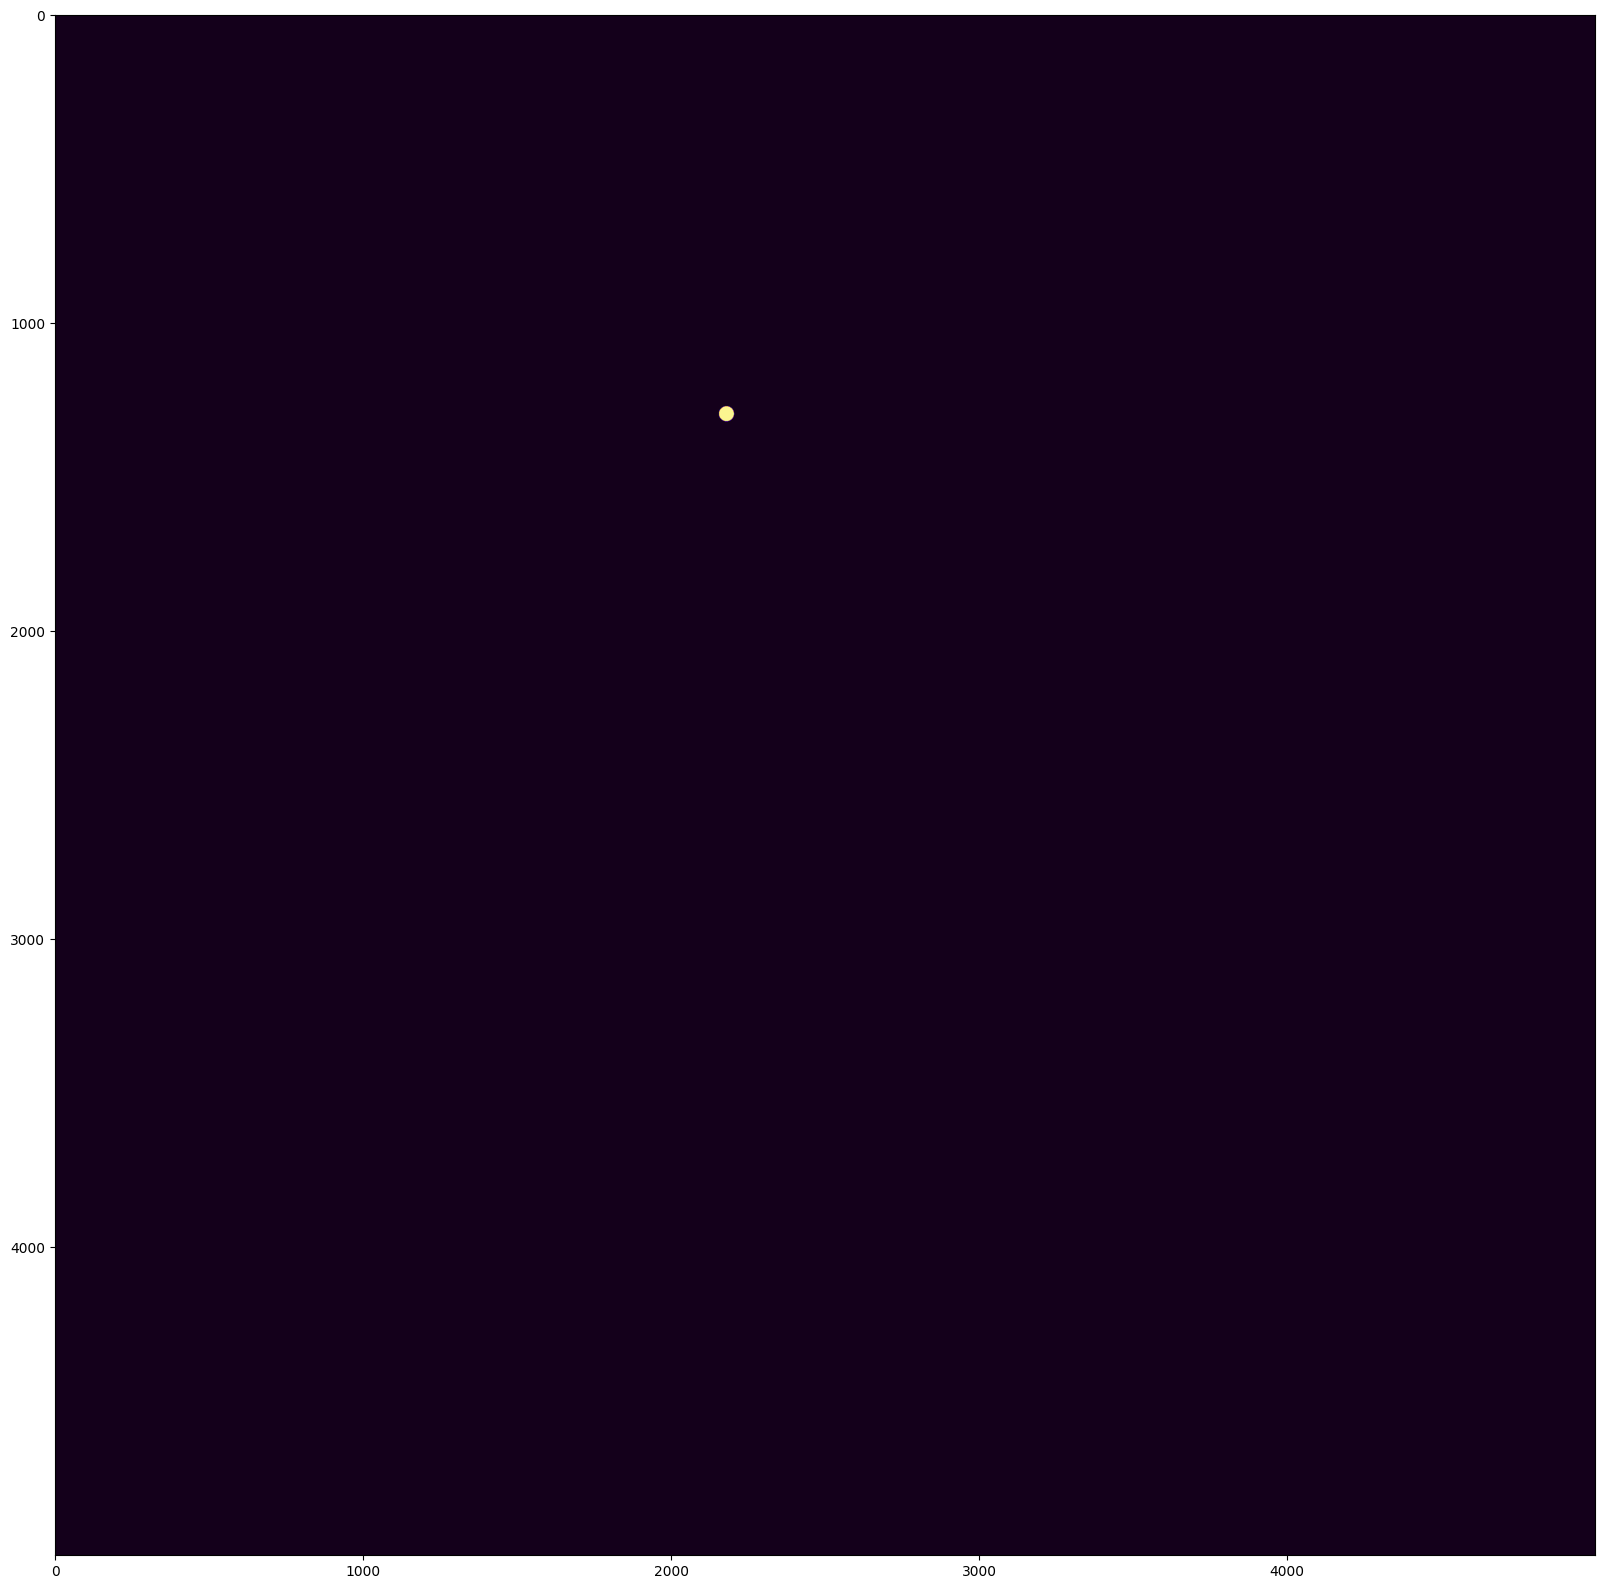

In [45]:
plt.figure(figsize=(20,20))
plt.imshow(mask_dw==24462, cmap='magma')
#plt.show()
#plt.figure(figsize=(20,20))
plt.imshow(seg_masks==1,alpha=0.3)

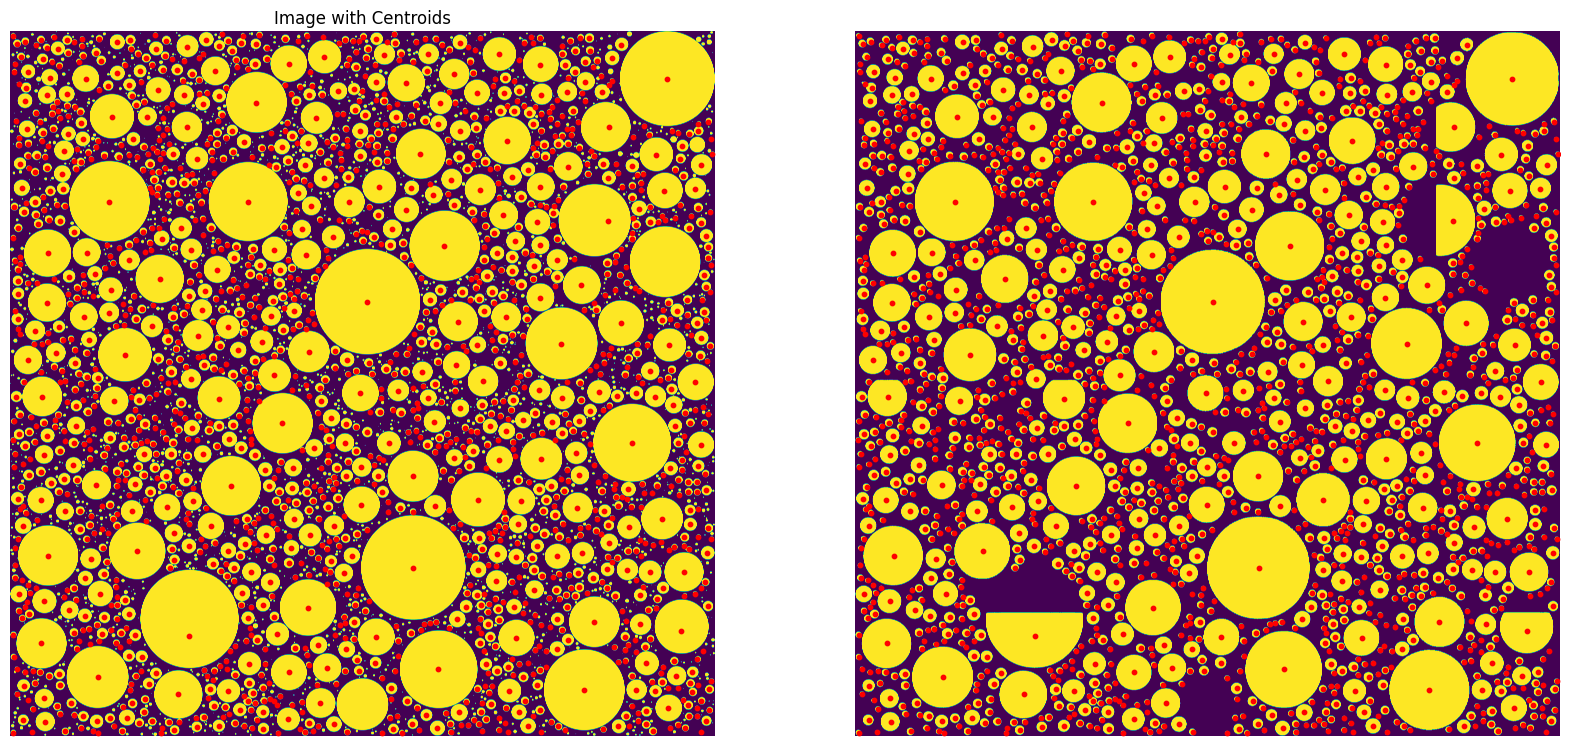

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(mask>0)

plt.scatter(centroids[1:, 1], centroids[1:, 0], color='red', s=10, label='Centroids')

plt.title('Image with Centroids')

plt.subplot(1,2,2)
plt.imshow(seg_masks_rs>0)
plt.scatter(centroids[1:, 1], centroids[1:, 0], color='red', s=10, label='Centroids')
plt.axis('off')

plt.show()

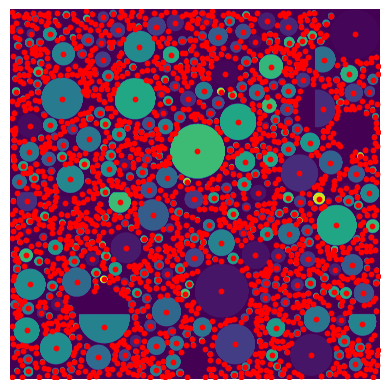

In [37]:
from skimage.measure import label, regionprops
centroids2=[]
labeled = label(seg_masks_rs)
regions = regionprops(labeled)

_, ax = plt.subplots()
ax.imshow(seg_masks_rs)
for reg in regions:
    centroids2.append(reg.centroid)
    ax.scatter(reg.centroid[1], reg.centroid[0], color='red', s=10)
ax.set_axis_off()

plt.show()

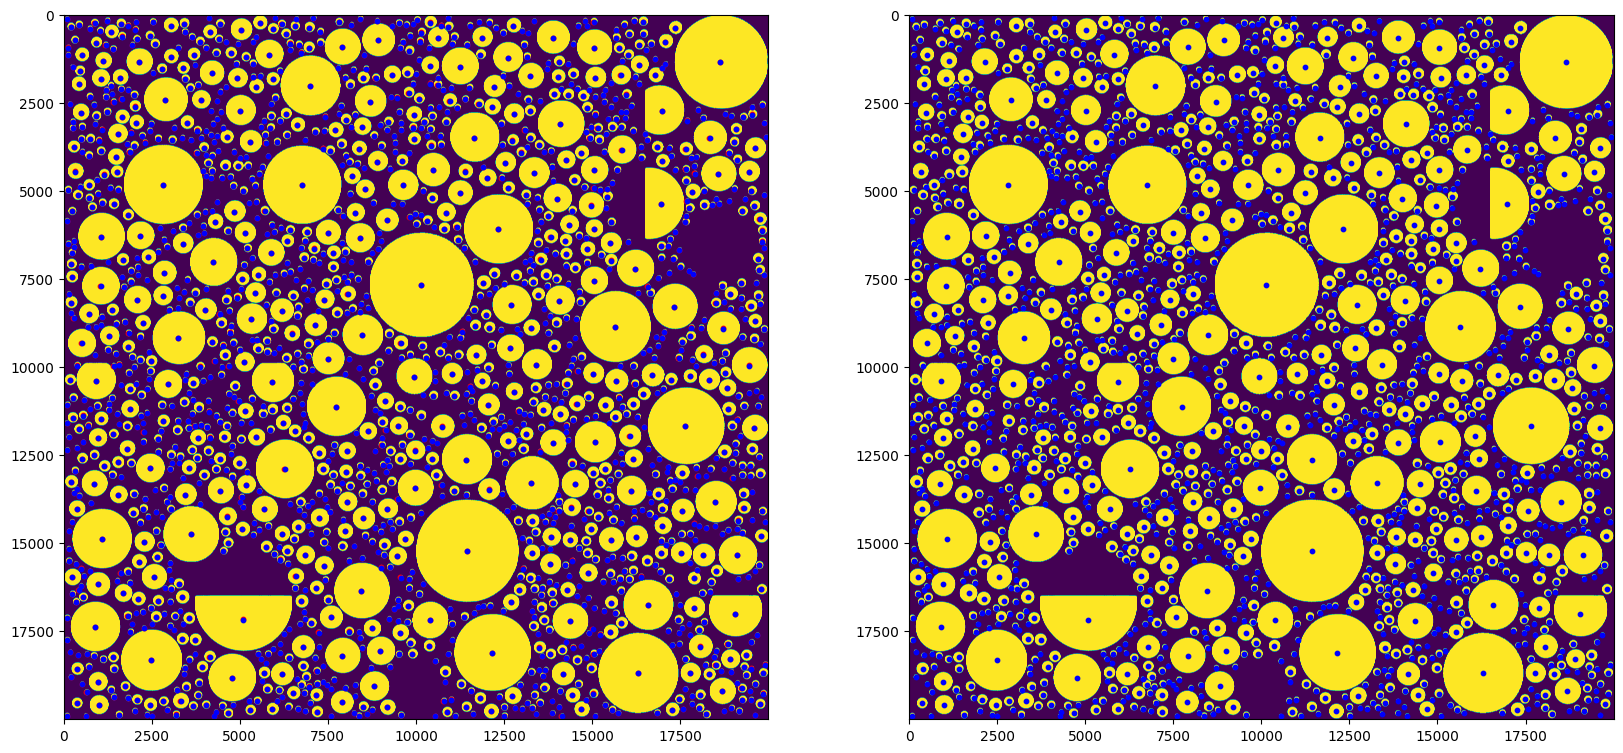

In [41]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(seg_masks_rs>0)
plt.scatter(centroids[1:, 1], centroids[1:, 0], color='red', s=10, label='Centroids')
plt.scatter(np.array(centroids2)[:, 1], np.array(centroids2)[:, 0], color='blue', s=10, label='Centroids')
plt.subplot(1,2,2)
plt.imshow(seg_masks_rs>0)
plt.scatter(np.array(centroids2)[:, 1], np.array(centroids2)[:, 0], color='blue', s=10, label='Centroids')